# Error distribution comparison

In [83]:
using NetCDF, PyPlot, ZfpCompression
using BitInformation, Statistics, StatsBase
using LinLogQuantization

In [84]:
path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path))
varname = "q"
file = filelist[[occursin(varname,f) for f in filelist]][1]

# load file
ncfile = NetCDF.open(joinpath(path,file))
X = ncfile.vars[varname][:,:,:];

In [85]:
keepbits = 7

7

# Decimal error

In [238]:
function decimal_error(X::AbstractArray{T},Y::AbstractArray{T}) where T
    X0 = X .== zero(T)
    Y0 = Y .== zero(T)

    Xs = signbit.(X)
    Ys = signbit.(Y)
    
    E = abs.(log10.(abs.(X./Y)))

    E[Xs .⊻ Ys] .= Inf        # signs don't match
    E[X0 .⊻ Y0] .= Inf        # one is zero the other one not
    E[X0 .& Y0] .= zero(T)    # both zero, set decimal error to zero
    
    return E
end

decimal_error (generic function with 2 methods)

## Compress, decompress

In [104]:
X1 = round(X,keepbits)
X2 = exp.(zfp_decompress(zfp_compress(log.(X),precision=16,nthreads=4)));

In [263]:
X3 = zfp_decompress(zfp_compress(X,tol=5e-7,nthreads=4))
X4 = zfp_decompress(zfp_compress(X,precision=13,nthreads=4))
X5 = exp.(zfp_decompress(zfp_compress(log.(X),tol=0.1,nthreads=4)));

## Calculate errors

In [264]:
# abs_error1 = sort(vec(abs.(X-X1)))/mean(X)
# abs_error2 = sort(vec(abs.(X-X2)))/mean(X)
abs_error3 = sort(vec(abs.(X-X3)))/mean(X)
# abs_error4 = sort(vec(abs.(X-X4)))/mean(X)
# abs_error5 = sort(vec(abs.(X-X5)))/mean(X)
# dec_error1 = sort(vec(decimal_error(X,X1)))
# dec_error2 = sort(vec(decimal_error(X,X2)))
dec_error3 = sort(vec(decimal_error(X,X3)))
# dec_error4 = sort(vec(decimal_error(X,X4)))
# dec_error5 = sort(vec(decimal_error(X,X5)));

In [265]:
percentiles = [50,90,100]
P = fill(0.0,2,5,length(percentiles))   # abs/dec x round/zfp x p

for (i,p) in enumerate(percentiles)
    for (j,(a,d)) in enumerate(zip([abs_error1,abs_error2,abs_error3,abs_error4,abs_error5],
                        [dec_error1,dec_error2,dec_error3,dec_error4,dec_error5]))
        P[1,j,i] = quantile(a,p/100,sorted=true)
        P[2,j,i] = quantile(d,p/100,sorted=true)
    end
end

In [283]:
P[.~isfinite.(P)] .= 1e10

2-element view(::Vector{Float64}, [26, 28]) with eltype Float64:
 1.0e10
 1.0e10

## Histograms

In [107]:
amin = 0
amax = max(maximum(abs_error1),maximum(abs_error2))
nbins = 500
Δ = (amax-amin)/nbins
binsabs = collect(amin:Δ:amax)

H1abs = fit(Histogram,abs_error1,binsabs)
H2abs = fit(Histogram,abs_error2,binsabs);

In [108]:
dmin = 0
dmax = max(maximum(dec_error1),maximum(dec_error2))
nbins = 500
Δ = (dmax-dmin)/nbins
binsdec = collect(dmin:Δ:dmax)

H1dec = fit(Histogram,dec_error1,binsdec)
H2dec = fit(Histogram,dec_error2,binsdec);

## Plotting

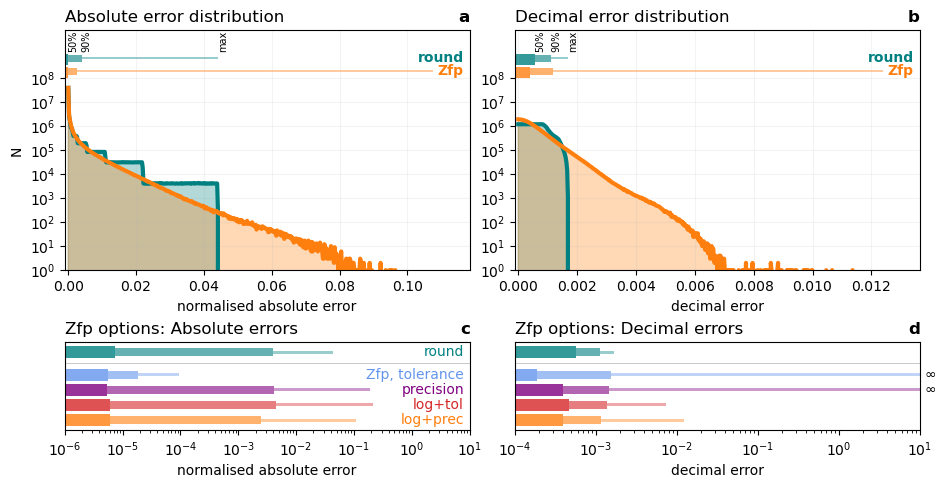

In [310]:
fig = figure(figsize=(9,4))

ax1 = fig.add_axes([0,0.4,.45,0.6])
ax2 = fig.add_axes([0.5,0.4,.45,0.6])
ax3 = fig.add_axes([0,0,.45,.22])
ax4 = fig.add_axes([0.5,0,.45,.22])

ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax4.set_xscale("log")
ax3.invert_yaxis()
ax4.invert_yaxis()


ax1.plot(binsabs[1:end-1],H1abs.weights,"teal",lw=3)
ax1.plot(binsabs[1:end-1],H2abs.weights,"C1",lw=3)
ax1.fill_between(binsabs[1:end-1],H1abs.weights,color="teal",alpha=.3)
ax1.fill_between(binsabs[1:end-1],H2abs.weights,color="C1",alpha=.3)

for (iax,ax) in enumerate([ax1,ax2])
    for (y,i,c) in zip([7e8,2e8],[1,2],["teal","C1"])
        ax.barh(y,abs(ax1min)+P[iax,i,1],height=y,left=ax1min,color=c,alpha=.8)
        ax.barh(y,P[iax,i,2]-P[iax,i,1],height=y/1.5,left=P[iax,i,1],color=c,alpha=.6)
        ax.barh(y,P[iax,i,3]-P[iax,i,2],height=y/4,left=P[iax,i,2],color=c,alpha=.4)
    end
end

labls = ["round","log+prec","Zfp, tolerance","precision","log+tol"]

for (iax,ax) in enumerate([ax3,ax4])
    for (y,i,c,l) in zip([0.5,5,2,3,4],[1,2,3,4,5],["teal","C1","cornflowerblue","purple","C3"],labls)
        ax.barh(y,P[iax,i,1],height=0.8,color=c,alpha=.8)
        ax.barh(y,P[iax,i,2]-P[iax,i,1],height=0.5,left=P[iax,i,1],color=c,alpha=.6)
        ax.barh(y,P[iax,i,3]-P[iax,i,2],height=0.2,left=P[iax,i,2],color=c,alpha=.4)
        if iax == 1
            ax.text(8,y,l,va="center",ha="right",color=c)
        end
    end
end

ax2.plot(binsdec[1:end-1],H1dec.weights,"teal",lw=3)
ax2.plot(binsdec[1:end-1],H2dec.weights,"C1",lw=3)
ax2.fill_between(binsdec[1:end-1],H1dec.weights,color="teal",alpha=.3)
ax2.fill_between(binsdec[1:end-1],H2dec.weights,color="C1",alpha=.3)

ax1min = amin-(amax-amin)/100
ax2min = dmin-(dmax-dmin)/100
ax1.set_xlim(ax1min,amax+(amax-amin)/10)
ax2.set_xlim(ax2min,dmax+(dmax-dmin)/10)
ax1.set_ylim(1,1e10)
ax2.set_ylim(1,1e10)
ax3.set_xlim(1e-6,10)
ax4.set_xlim(1e-4,10)

ytiks = 10 .^ collect(0:8)
ax1.set_yticks(ytiks)
ax2.set_yticks(ytiks)
ax3.set_yticks([])
ax4.set_yticks([])

ax1.set_title("Absolute error distribution",loc="left")
ax2.set_title("Decimal error distribution",loc="left")
ax3.set_title("Zfp options: Absolute errors",loc="left")
ax4.set_title("Zfp options: Decimal errors",loc="left")

ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax3.set_title("c",loc="right",fontweight="bold")
ax4.set_title("d",loc="right",fontweight="bold")
ax1.set_ylabel("N")
ax1.set_xlabel("normalised absolute error")
ax2.set_xlabel("decimal error")
ax3.set_xlabel("normalised absolute error")
ax4.set_xlabel("decimal error")

xmax = amax+(amax-amin)/12
ax1.text(xmax,7e8,"round",color="teal",fontweight="bold",ha="right",va="center")
ax1.text(xmax,2e8,"Zfp",color="C1",fontweight="bold",ha="right",va="center")

xmax = dmax+(dmax-dmin)/12
ax2.text(xmax,7e8,"round",color="teal",fontweight="bold",ha="right",va="center")
ax2.text(xmax,2e8,"Zfp",color="C1",fontweight="bold",ha="right",va="center")
ax1.text(P[1,1,1],1.5e9,"50%",rotation=90,fontsize=7)
ax1.text(P[1,1,2],1.5e9,"90%",rotation=90,fontsize=7)
ax1.text(P[1,1,3],1.5e9,"max",rotation=90,fontsize=7)
ax2.text(P[2,1,1],1.5e9,"50%",rotation=90,fontsize=7)
ax2.text(P[2,1,2],1.5e9,"90%",rotation=90,fontsize=7)
ax2.text(P[2,1,3],1.5e9,"max",rotation=90,fontsize=7)

ax3.axhline(1.25,c="k",alpha=.3,lw=0.5)
ax4.axhline(1.25,c="k",alpha=.3,lw=0.5)

ax4.text(1.01,0.6,L"\infty",transform=ax4.transAxes)
ax4.text(1.01,0.42,L"\infty",transform=ax4.transAxes)

ax1.grid(alpha=.15)
ax2.grid(alpha=.15)